In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from analysis.heatmap_analysis import generate_heatmap
import itertools
from functools import partial
import pdb

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
    seq_contains_mdm2_motif,
)
from analysis.scatter_plots import (
    plot_relations,
    plot_relations_in_3D,
    plot_relations_in_plotly
)
from utils.utils import seed_everything
from models.rnn import multi_channel_mse, er_rmse, fold_rmse, p_value_rmse

2023-03-29 22:09:04.415794: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 22:09:05.000856: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-29 22:09:07.125966: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-03-29 22:09:07.126850: W ten

In [2]:
protein_of_interest = "MDM2"
other_protein = "12ca5"

X, y_raw, peptides = data_loading.build_joint_dataset(
    er_datafile =f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-R3.csv",
    protein_of_interest=protein_of_interest, 
    other_protein=other_protein
)

/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


In [3]:
def cross_validate_and_benchmark(
    model_save_name="final_models/Joint_loss_model.h5",
    loss=multi_channel_mse,
    load_trained_model=True,
    calculate_proxy_uncertainty=True,
    ranking_lambda=lambda x: x[2] + x[0] + x[1],
    plot_x_idx=1,  # TODO: these arguments are not clear in the least... make these clearer
    plot_y_idx=0,  # TODO: these arguments are not clear in the least... make these clearer
    width=64
):
    seed_everything(0)
    results = experiment.Experiment().run_cross_validation_experiment(
        X=X,
        y=y_raw,
        model_architecture=partial(rnn.ThreeChannelRegressionRNN_gelu, loss=loss, width=width),
        optimizer=partial(
            keras.optimizers.Adam, learning_rate=0.0005, weight_decay=0.5
        ),
        n_splits=10,
        load_trained_model=load_trained_model,
        model_save_name=model_save_name,
        normalize=True,
        batch_size=128,
        num_epochs=5,
    )

    y_pred = np.vstack(result.y_pred for result in results)
    y_true = np.vstack(result.y_test for result in results)
    # Check that the cross folds experiment returns our y_true in the same order as before
    assert (y_true == y_raw).all()

    all_positives = np.array(
        [1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides]
    )
    if calculate_proxy_uncertainty:
        # Calculate with dropout on...
        pred_100_fold = []
        for result in results:
            pred_100_fold.append(
                np.array(
                    [
                        result.trained_model(result.X_test, training=True)
                        for _ in range(100)
                    ]
                )
            )
        pred_100_fold = np.concatenate(pred_100_fold, axis=1)

        mean = np.mean(pred_100_fold, axis=0)
        variance = np.std(pred_100_fold, axis=0)
        uncertainty = np.mean(variance, axis=1)

        mdm2_ordering = [ranking_lambda(pred) for pred in mean]
        plot_relations_in_3D(
            plot_x_idx,
            plot_y_idx,
            datapoints=mean,
            title="Predicted Hits Coloring",
            ordering=mdm2_ordering,
            all_positives=all_positives,
            uncertainty=uncertainty,
        )
    else:
        mdm2_ordering = [ranking_lambda(pred) for pred in y_pred]
        plot_relations(
            plot_x_idx,
            plot_y_idx,
            datapoints=y_pred,
            ordering=mdm2_ordering,
            all_positives=all_positives,
            kind="scatter",
        )
    plot_ratio_by_ranking(
        peptides=peptides,
        ca5_y_ranking=None,
        mdm2_y_ranking=mdm2_ordering,
        title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On All Samples)",
        plot_theoretical_maximums=True,
        peptide_dataset_size=500,
    )


# Joint Model

2023-03-29 22:09:39.508615: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


/tmp/ipykernel_25152/3785829286.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred for result in results)
/tmp/ipykernel_25152/3785829286.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for result in results)


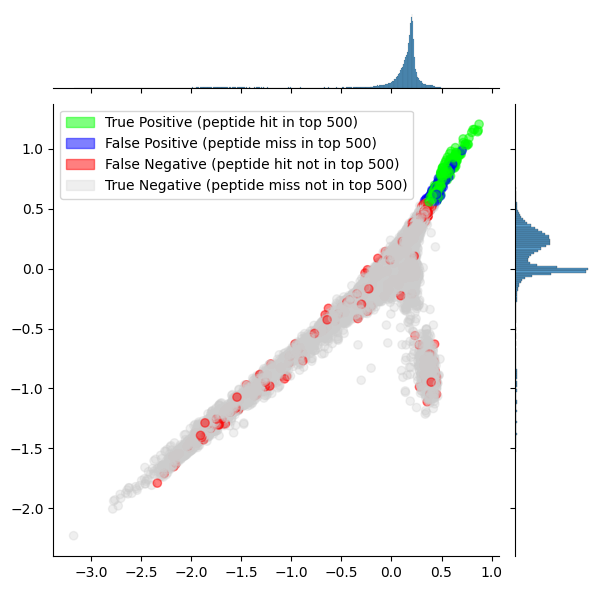

MDM2 area under curve:  360.81393841373307
normalized MDM2 area under curve:  0.7216278768274661


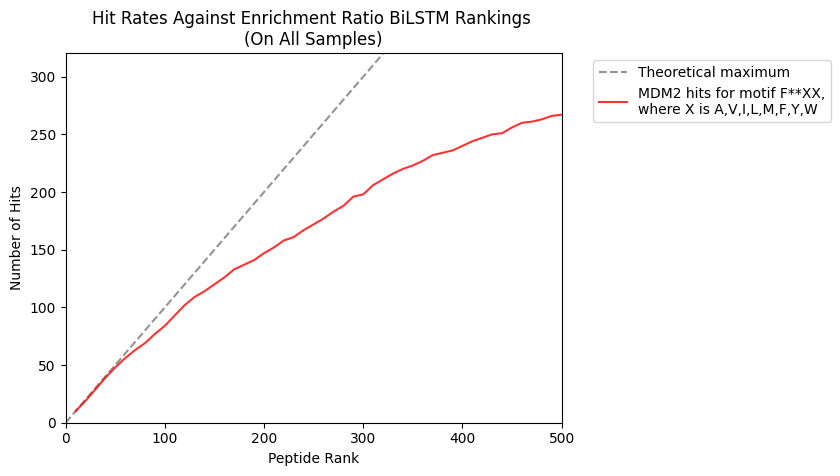

In [4]:
cross_validate_and_benchmark(
    model_save_name="final_models/Joint_loss_model.h5",
    loss=multi_channel_mse,
    load_trained_model=True,
    calculate_proxy_uncertainty=False,
    ranking_lambda=lambda x: x[0] + x[1] + x[2],
    plot_x_idx=1,
    plot_y_idx=2,
    width=128
)

With 100 fold uncertainty calculation to help zero in on the mean

2023-03-29 22:17:50.048023: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_25152/3785829286.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred for result in results)
/tmp/ipykernel_25152/3785829286.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for res

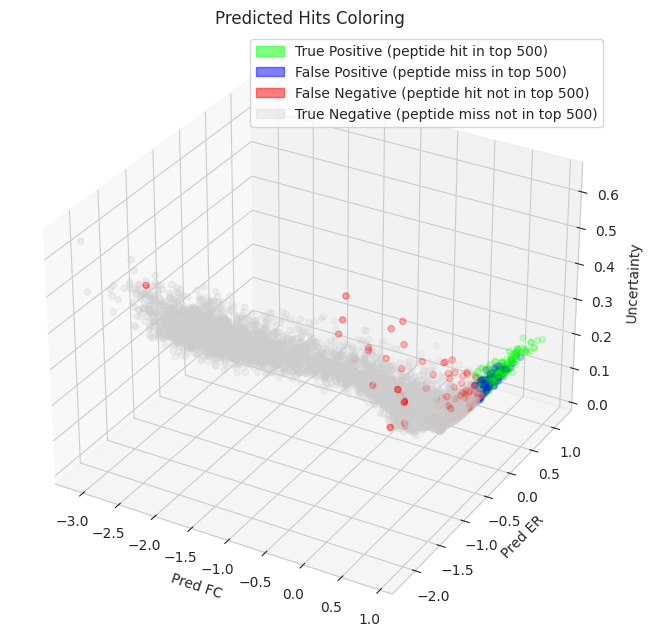

MDM2 area under curve:  370.1767048785702
normalized MDM2 area under curve:  0.7417037394392317


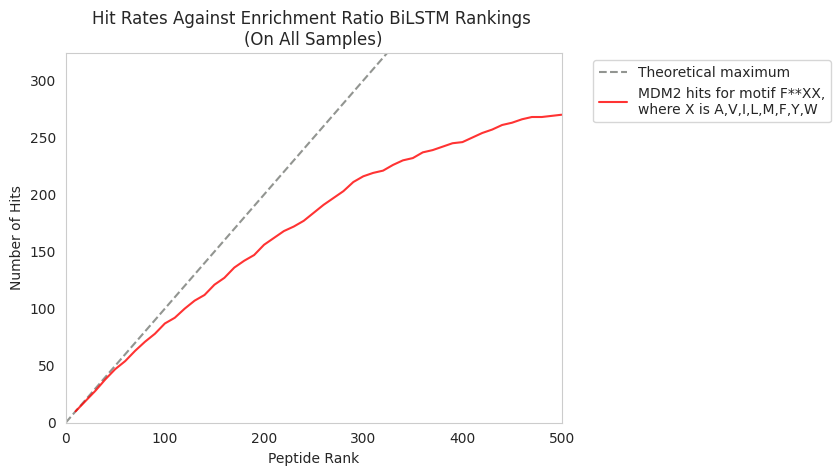

In [6]:
cross_validate_and_benchmark(
    model_save_name="final_models/Joint_loss_model.h5",
    loss=multi_channel_mse,
    load_trained_model=True,
    calculate_proxy_uncertainty=True,
    ranking_lambda=lambda x: x[0] + x[1] + x[2],
    plot_x_idx=1,
    plot_y_idx=2,
    width=128
)

In [ ]:
plot_ratio_by_ranking(
    peptides=peptides,
    ca5_y_ranking=None,
    mdm2_y_ranking=mdm2_ordering,
    title="Hit Rates Against Enrichment Ratio BiLSTM Rankings \n(On All Samples)",
    plot_theoretical_maximums=True,
    peptide_dataset_size=500,
)


# Just Fold Change

2023-03-23 15:06:31.691298: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_3802/3785829286.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred for result in results)
/tmp/ipykernel_3802/3785829286.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for resul

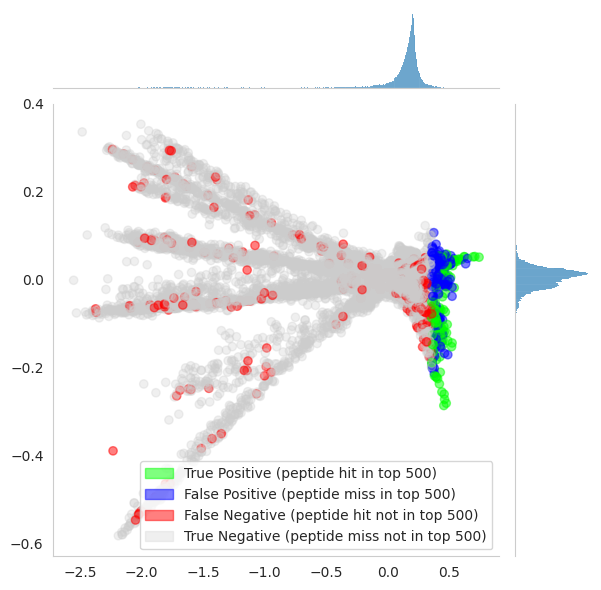

MDM2 area under curve:  245.55214824481573
normalized MDM2 area under curve:  0.49110429648963144


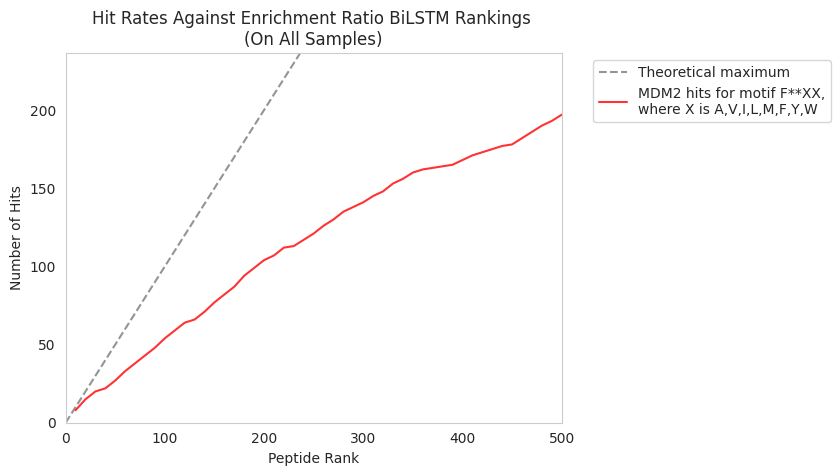

In [10]:
cross_validate_and_benchmark(
    model_save_name=f"final_models/FC_loss_model.h5",
    loss=fold_rmse,
    load_trained_model=True,
    calculate_proxy_uncertainty=False,
    ranking_lambda=lambda x: x[1],
)

With 100 fold uncertainty prediction to help zero in on the mean

2023-03-23 15:07:18.628264: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_3802/3785829286.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred for result in results)
/tmp/ipykernel_3802/3785829286.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for resul

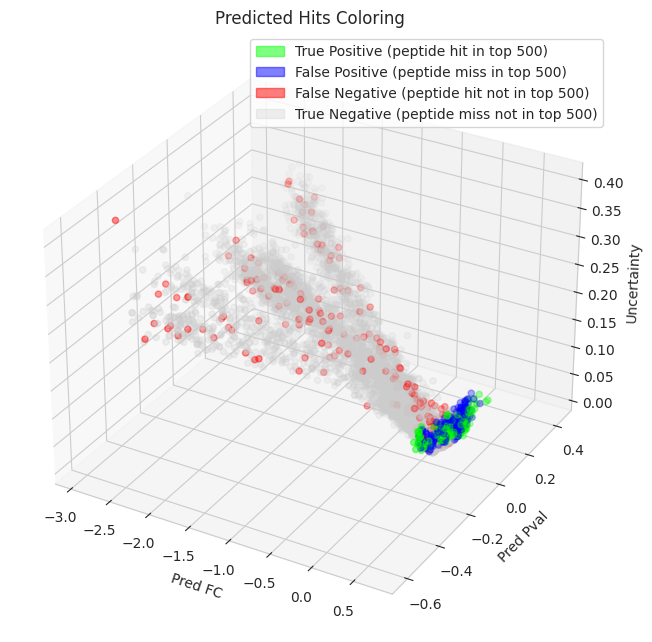

MDM2 area under curve:  268.8865584776308
normalized MDM2 area under curve:  0.5377731169552615


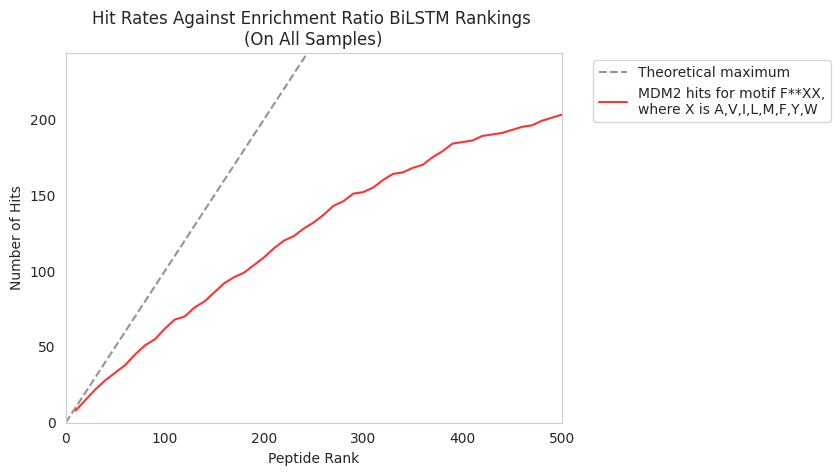

In [11]:
cross_validate_and_benchmark(
    model_save_name="final_models/FC_loss_model.h5",
    loss=fold_rmse,
    load_trained_model=True,
    calculate_proxy_uncertainty=True,
    ranking_lambda=lambda x: x[1],
)

# Now just PVal

2023-03-23 15:11:10.381643: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_3802/3785829286.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred for result in results)
/tmp/ipykernel_3802/3785829286.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for resul

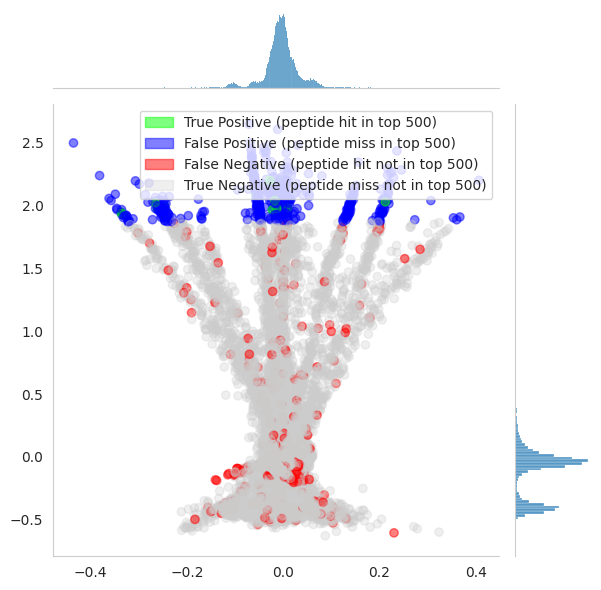

MDM2 area under curve:  18.983672979404854
normalized MDM2 area under curve:  0.03796734595880971


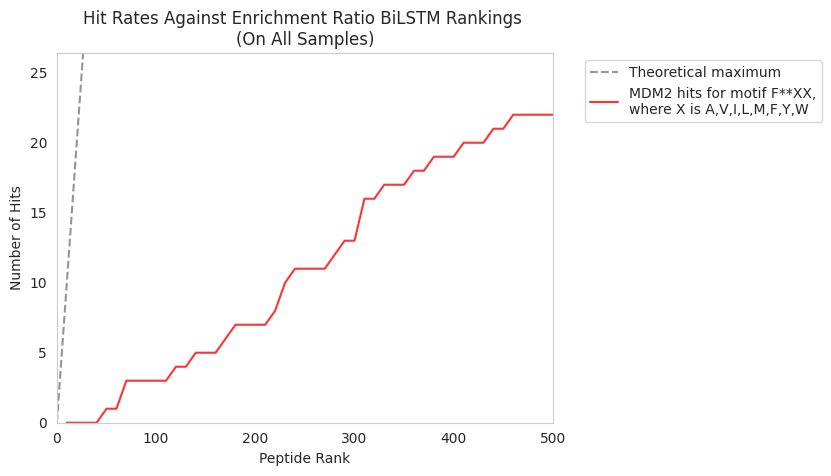

In [12]:
cross_validate_and_benchmark(
    model_save_name=f"final_models/PVal_loss_model.h5",
    loss=p_value_rmse,
    load_trained_model=True,
    calculate_proxy_uncertainty=False,
    ranking_lambda=lambda x: x[0],
)

With uncertainty calculations to help zero in on the mean

2023-03-23 15:12:01.674790: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_3802/3785829286.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred for result in results)
/tmp/ipykernel_3802/3785829286.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for resul

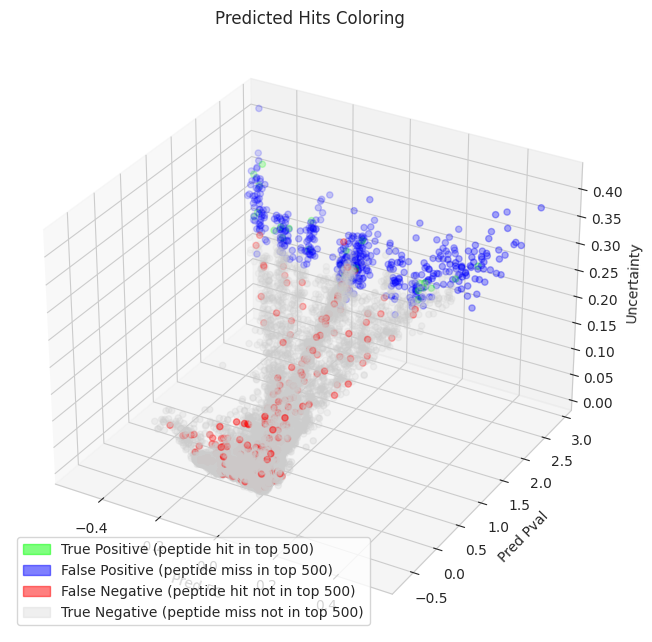

MDM2 area under curve:  26.60178882039652
normalized MDM2 area under curve:  0.053203577640793046


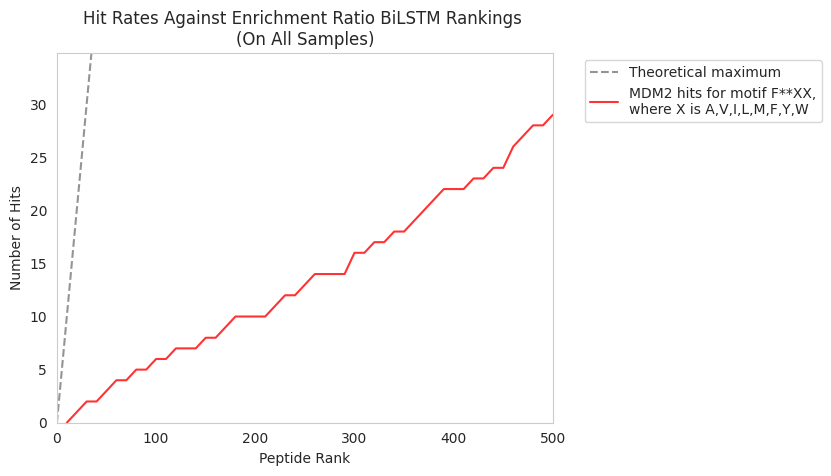

In [13]:
cross_validate_and_benchmark(
    model_save_name=f"final_models/PVal_loss_model.h5",
    loss=p_value_rmse,
    load_trained_model=True,
    calculate_proxy_uncertainty=True,
    ranking_lambda=lambda x: x[0],
)

# Now Just ER

2023-03-23 15:15:56.026705: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_3802/3785829286.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred for result in results)
/tmp/ipykernel_3802/3785829286.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for resul

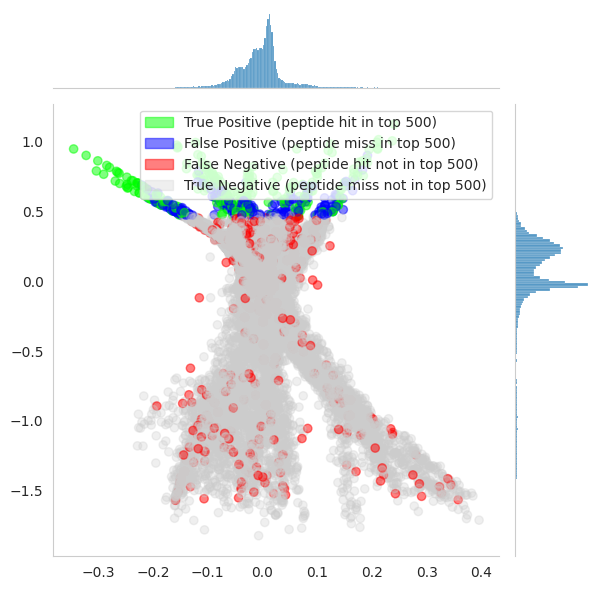

MDM2 area under curve:  384.54081350292074
normalized MDM2 area under curve:  0.7690816270058415


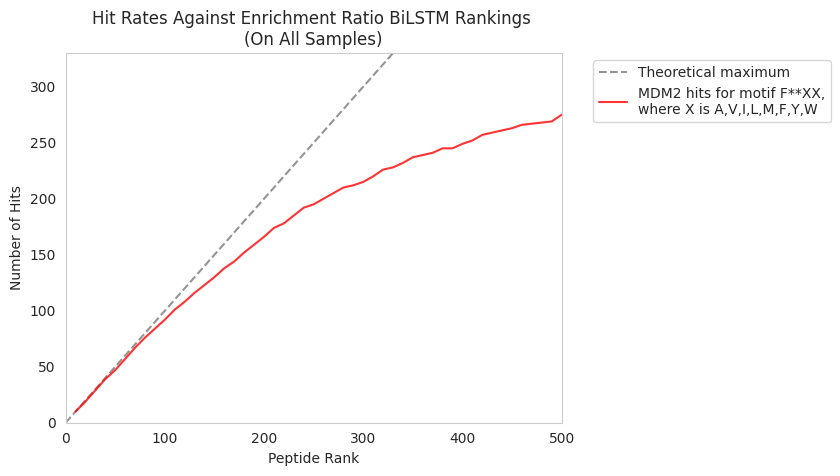

In [14]:
cross_validate_and_benchmark(
    model_save_name="final_models/ER_loss_model.h5",
    loss=er_rmse,
    load_trained_model=True,
    calculate_proxy_uncertainty=False,
    ranking_lambda=lambda x: x[2],
    plot_x_idx=1, 
    plot_y_idx=2, 
)

With 100 Fold uncertainty calculations to help zero in on the mean

2023-03-23 15:16:42.428654: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/tmp/ipykernel_3802/3785829286.py:27: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_pred = np.vstack(result.y_pred for result in results)
/tmp/ipykernel_3802/3785829286.py:28: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(result.y_test for resul

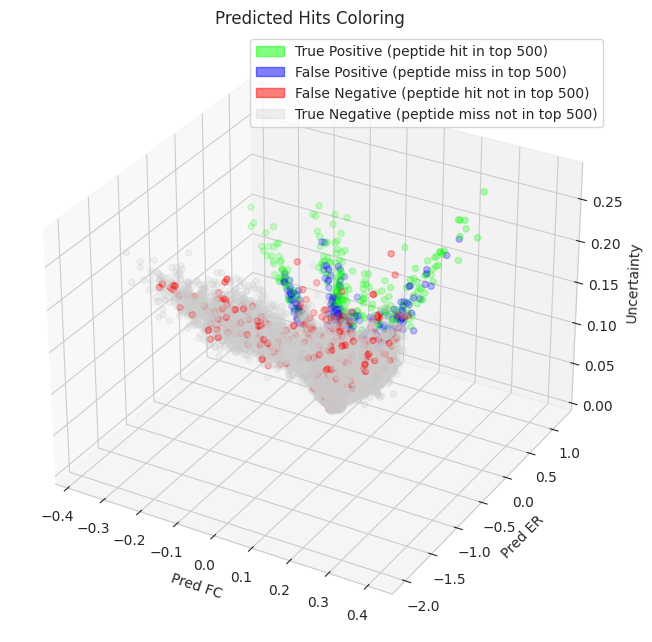

MDM2 area under curve:  381.15811927738156
normalized MDM2 area under curve:  0.7623162385547632


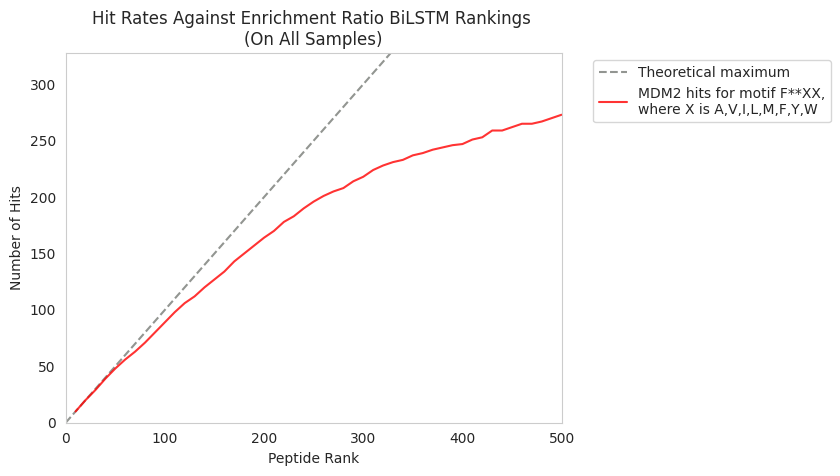

In [15]:
cross_validate_and_benchmark(
    model_save_name="final_models/ER_loss_model.h5",
    loss=er_rmse,
    load_trained_model=True,
    calculate_proxy_uncertainty=True,
    ranking_lambda=lambda x: x[2],
    plot_x_idx=1, 
    plot_y_idx=2, 
)